Fitting 5 folds for each of 32 candidates, totalling 160 fits
Лучший классификатор:  SVC(C=10)
Accuracy: 0.86
Recall: 0.84
Precision: 0.88
F1-score: 0.85
Число опорных векторов:  [26 13  6  8 22 12  7  4  5  5  8 28  3  8 26  7  9  7]


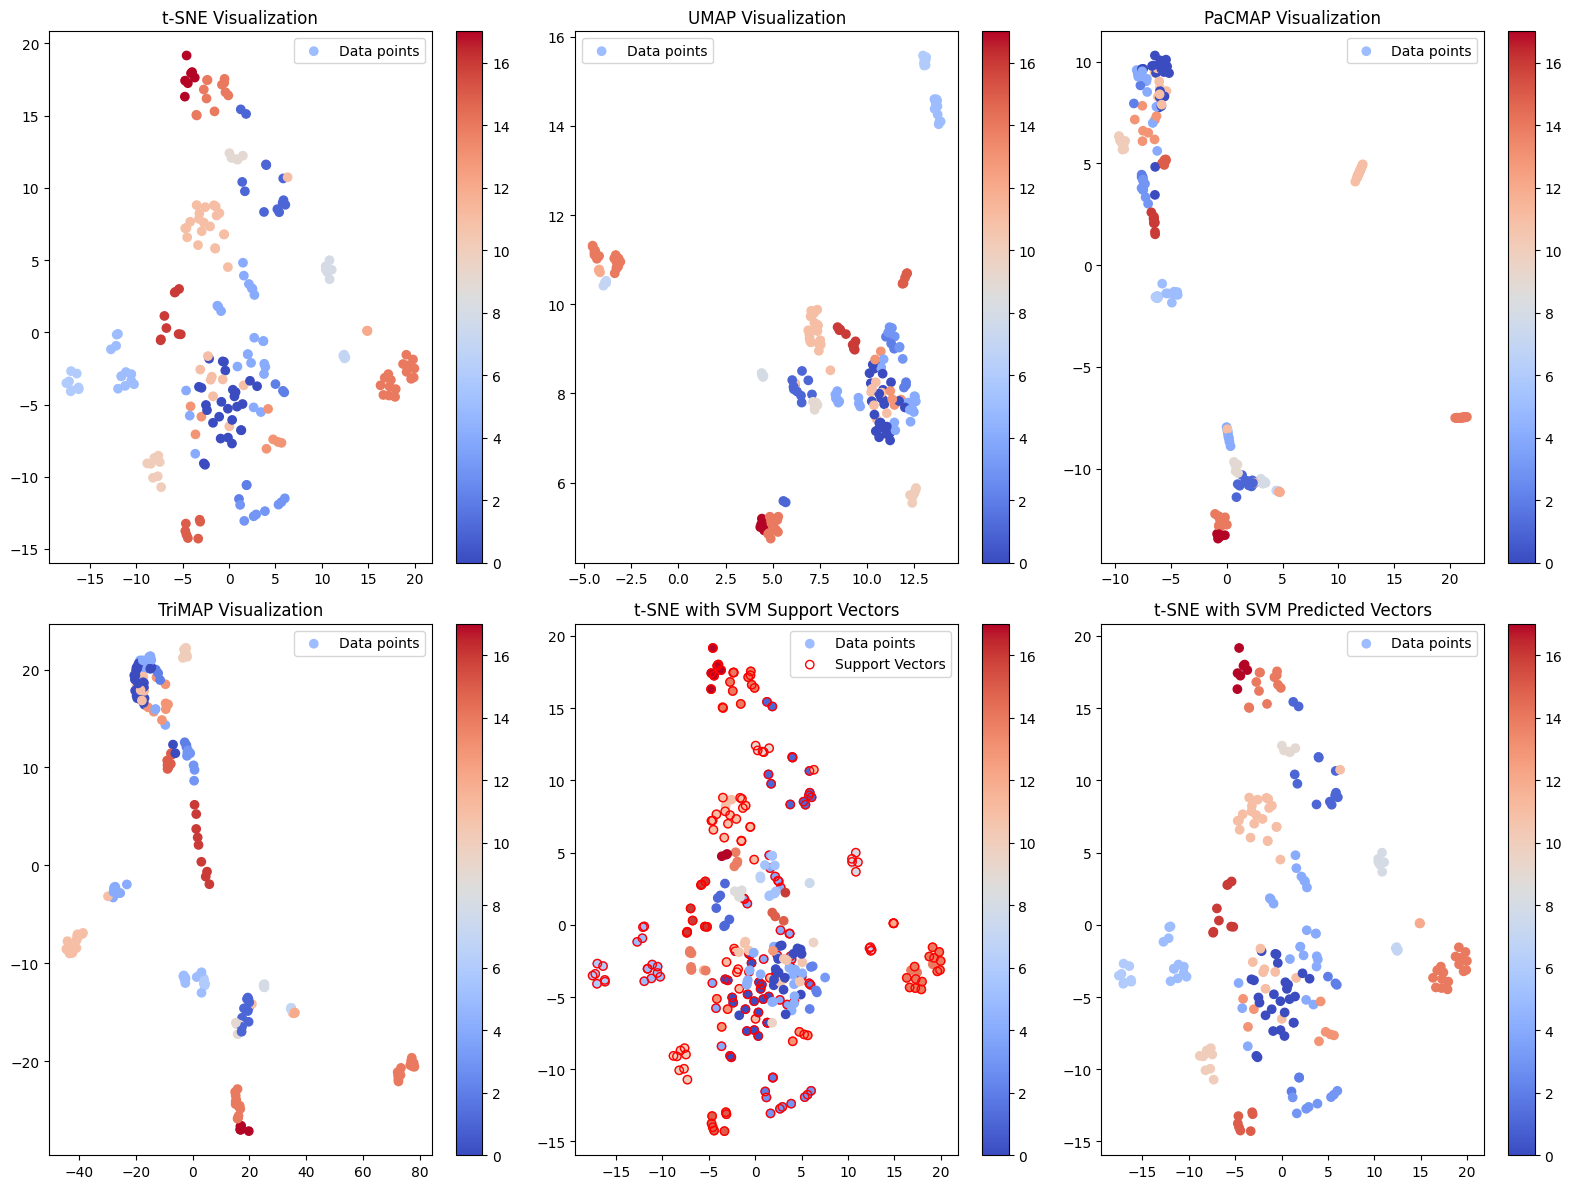

In [18]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from umap import UMAP
import pacmap
import trimap
import warnings

warnings.filterwarnings("ignore")

# Загружаем данные
post_operative_patient = fetch_ucirepo(id=90)  # Используем UCI ML репозиторий
X = post_operative_patient.data.features
y = post_operative_patient.data.targets

encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Параметры для GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Обучение модели с перебором параметров по сетке
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Выводим лучший классификатор
best_svm = grid_search.best_estimator_
print("Лучший классификатор: ", best_svm)

# Оценка на тестовых данных
y_pred = best_svm.predict(X_test_scaled)

# Метрики качества
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1-score: {f1:.2f}")

# Число опорных векторов
print("Число опорных векторов: ", best_svm.n_support_)

# Преобразуем данные для визуализации
X_train_embedded = X_train_scaled  # Используем обучающие данные для визуализации

# Визуализация с t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_embedded)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Создаем subplots для 5 графиков (2 строки, 3 столбца, оставляем один график пустым)
fig, axs = plt.subplots(2, 3, figsize=(16, 12))

# Визуализация с t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_embedded)
axs[0, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train_encoded, cmap='coolwarm', label='Data points')
axs[0, 0].set_title('t-SNE Visualization')
axs[0, 0].legend()
axs[0, 0].colorbar = plt.colorbar(axs[0, 0].collections[0], ax=axs[0, 0])

# Визуализация с UMAP
umap_model = UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_train_embedded)
axs[0, 1].scatter(X_umap[:, 0], X_umap[:, 1], c=y_train_encoded, cmap='coolwarm', label='Data points')
axs[0, 1].set_title('UMAP Visualization')
axs[0, 1].legend()
axs[0, 1].colorbar = plt.colorbar(axs[0, 1].collections[0], ax=axs[0, 1])

# Визуализация с PaCMAP
pacmap_model = pacmap.PaCMAP(random_state=42)
X_pacmap = pacmap_model.fit_transform(X_train_embedded)
axs[0, 2].scatter(X_pacmap[:, 0], X_pacmap[:, 1], c=y_train_encoded, cmap='coolwarm', label='Data points')
axs[0, 2].set_title('PaCMAP Visualization')
axs[0, 2].legend()
axs[0, 2].colorbar = plt.colorbar(axs[0, 2].collections[0], ax=axs[0, 2])

# Визуализация с TriMAP
trimap_model = trimap.TRIMAP(n_dims=2)
X_trimap = trimap_model.fit_transform(X_train_embedded)
axs[1, 0].scatter(X_trimap[:, 0], X_trimap[:, 1], c=y_train_encoded, cmap='coolwarm', label='Data points')
axs[1, 0].set_title('TriMAP Visualization')
axs[1, 0].legend()
axs[1, 0].colorbar = plt.colorbar(axs[1, 0].collections[0], ax=axs[1, 0])

# Визуализация t-SNE с опорными векторами SVM
axs[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train_encoded, cmap='coolwarm', label='Data points')
axs[1, 1].scatter(X_tsne[best_svm.support_, 0], X_tsne[best_svm.support_, 1], facecolors='none', edgecolors='r', label='Support Vectors')
axs[1, 1].set_title('t-SNE with SVM Support Vectors')
axs[1, 1].legend()
axs[1, 1].colorbar = plt.colorbar(axs[1, 1].collections[0], ax=axs[1, 1])

# Визуализация t-SNE с опорными векторами SVM
X_tsne_test = tsne.fit_transform(X_test)
y_pred_encoded = label_encoder.fit_transform(y_pred)

axs[1, 2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train_encoded, cmap='coolwarm', label='Data points')
axs[1, 1].scatter(X_tsne_test[:, 0], X_tsne_test[:, 1], c=y_pred_encoded, cmap='coolwarm', label='Predicted Labels')
axs[1, 2].set_title('t-SNE with SVM Predicted Vectors')
axs[1, 2].legend()
axs[1, 2].colorbar = plt.colorbar(axs[1, 1].collections[0], ax=axs[1, 2])

# Показ всех графиков
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Лучший классификатор KNN:  KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
Accuracy (KNN): 0.87
Recall (KNN): 0.84
Precision (KNN): 0.81
F1-score (KNN): 0.82


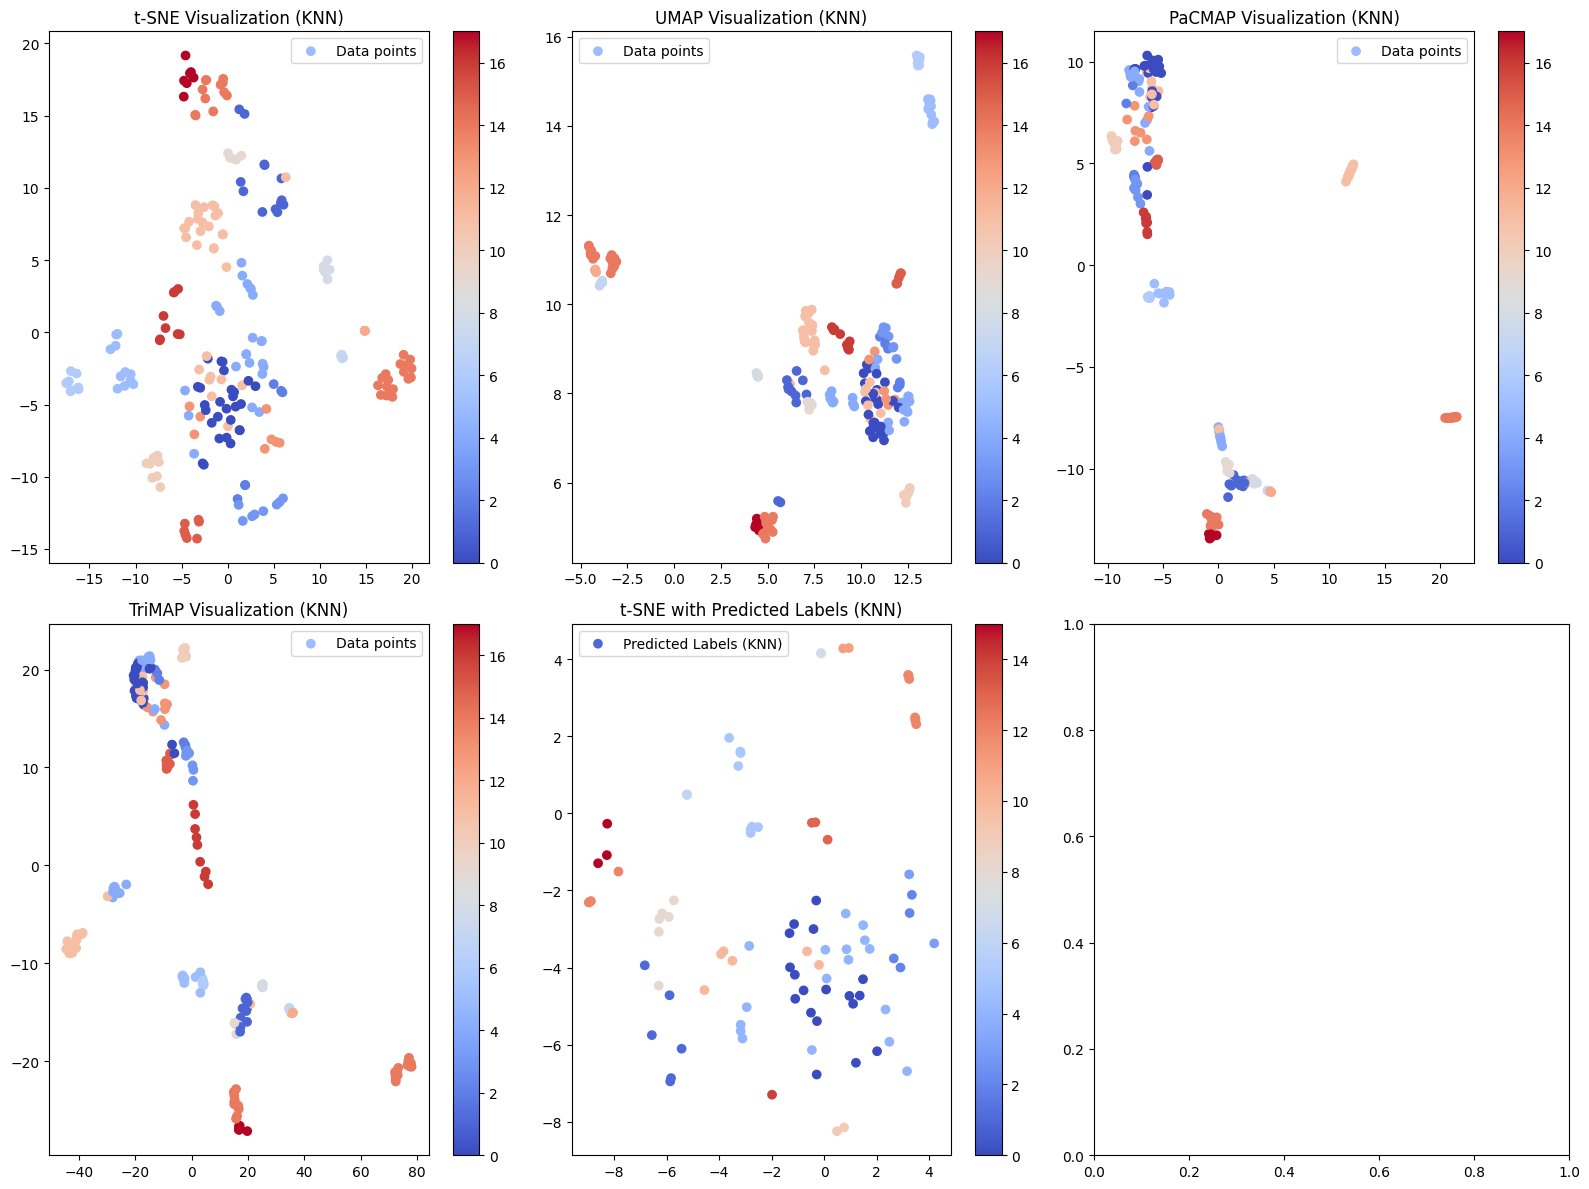

In [21]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from umap import UMAP
import pacmap
import trimap
import warnings

warnings.filterwarnings("ignore")

# Загружаем данные
post_operative_patient = fetch_ucirepo(id=90)  # Используем UCI ML репозиторий
X = post_operative_patient.data.features
y = post_operative_patient.data.targets

encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Параметры для GridSearchCV (перебор по числу соседей, метрикам и весам)
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # число соседей
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # метрика расстояния
    'weights': ['uniform', 'distance']  # правило голосования
}

# Обучение модели с перебором параметров по сетке
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search_knn.fit(X_train_scaled, y_train)

# Выводим лучший классификатор
best_knn = grid_search_knn.best_estimator_
print("Лучший классификатор KNN: ", best_knn)

# Оценка на тестовых данных
y_pred_knn = best_knn.predict(X_test_scaled)

# Метрики качества
accuracy_knn = accuracy_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn, average='macro')
precision_knn = precision_score(y_test, y_pred_knn, average='macro')
f1_knn = f1_score(y_test, y_pred_knn, average='macro')

print(f"Accuracy (KNN): {accuracy_knn:.2f}")
print(f"Recall (KNN): {recall_knn:.2f}")
print(f"Precision (KNN): {precision_knn:.2f}")
print(f"F1-score (KNN): {f1_knn:.2f}")

# Преобразуем данные для визуализации
X_train_embedded = X_train_scaled  # Используем обучающие данные для визуализации

# Создаем subplots для 5 графиков (2 строки, 3 столбца, оставляем один график пустым)
fig, axs = plt.subplots(2, 3, figsize=(16, 12))

# Визуализация с t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne_knn = tsne.fit_transform(X_train_embedded)
axs[0, 0].scatter(X_tsne_knn[:, 0], X_tsne_knn[:, 1], c=y_train_encoded, cmap='coolwarm', label='Data points')
axs[0, 0].set_title('t-SNE Visualization (KNN)')
axs[0, 0].legend()
axs[0, 0].colorbar = plt.colorbar(axs[0, 0].collections[0], ax=axs[0, 0])

# Визуализация с UMAP
umap_model = UMAP(n_components=2, random_state=42)
X_umap_knn = umap_model.fit_transform(X_train_embedded)
axs[0, 1].scatter(X_umap_knn[:, 0], X_umap_knn[:, 1], c=y_train_encoded, cmap='coolwarm', label='Data points')
axs[0, 1].set_title('UMAP Visualization (KNN)')
axs[0, 1].legend()
axs[0, 1].colorbar = plt.colorbar(axs[0, 1].collections[0], ax=axs[0, 1])

# Визуализация с PaCMAP
pacmap_model = pacmap.PaCMAP(random_state=42)
X_pacmap_knn = pacmap_model.fit_transform(X_train_embedded)
axs[0, 2].scatter(X_pacmap_knn[:, 0], X_pacmap_knn[:, 1], c=y_train_encoded, cmap='coolwarm', label='Data points')
axs[0, 2].set_title('PaCMAP Visualization (KNN)')
axs[0, 2].legend()
axs[0, 2].colorbar = plt.colorbar(axs[0, 2].collections[0], ax=axs[0, 2])

# Визуализация с TriMAP
trimap_model = trimap.TRIMAP(n_dims=2)
X_trimap_knn = trimap_model.fit_transform(X_train_embedded)
axs[1, 0].scatter(X_trimap_knn[:, 0], X_trimap_knn[:, 1], c=y_train_encoded, cmap='coolwarm', label='Data points')
axs[1, 0].set_title('TriMAP Visualization (KNN)')
axs[1, 0].legend()
axs[1, 0].colorbar = plt.colorbar(axs[1, 0].collections[0], ax=axs[1, 0])

# Визуализация t-SNE с предсказанными метками KNN
X_tsne_test_knn = tsne.fit_transform(X_test_scaled)
y_pred_knn_encoded = label_encoder.fit_transform(y_pred_knn)
axs[1, 1].scatter(X_tsne_test_knn[:, 0], X_tsne_test_knn[:, 1], c=y_pred_knn_encoded, cmap='coolwarm', label='Predicted Labels (KNN)')
axs[1, 1].set_title('t-SNE with Predicted Labels (KNN)')
axs[1, 1].legend()
axs[1, 1].colorbar = plt.colorbar(axs[1, 1].collections[0], ax=axs[1, 1])


# Показ всех графиков
plt.tight_layout()
plt.show()

In [8]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from umap import UMAP
import pacmap
import trimap
import warnings

warnings.filterwarnings("ignore")

# Загружаем данные
post_operative_patient = fetch_ucirepo(id=90) 
X = post_operative_patient.data.features
y = post_operative_patient.data.targets

encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Параметры для GridSearchCV (перебор по числу деревьев и другим параметрам)
param_grid = {
    'n_estimators': [100, 200, 300],  # число деревьев
    'max_depth': [None, 10, 20],  # максимальная глубина
    'min_samples_split': [2, 5, 10],  # минимальное число образцов для разделения
    'min_samples_leaf': [1, 2, 4],  # минимальное число образцов в листе
    'bootstrap': [True, False]  # использование подвыборки при построении деревьев
}

# Обучение модели с перебором параметров по сетке
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search_rf.fit(X_train_scaled, y_train)

# Выводим лучший классификатор
best_rf = grid_search_rf.best_estimator_
print("Лучший классификатор RF: ", best_rf)

# Оценка на тестовых данных
y_pred_rf = best_rf.predict(X_test_scaled)

# Метрики качества
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
precision_rf = precision_score(y_test, y_pred_rf, average='macro')
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

print(f"Accuracy (RF): {accuracy_rf:.2f}")
print(f"Recall (RF): {recall_rf:.2f}")
print(f"Precision (RF): {precision_rf:.2f}")
print(f"F1-score (RF): {f1_rf:.2f}")

# Преобразуем данные для визуализации
X_train_embedded = X_train_scaled  # Используем обучающие данные для визуализации

# Создаем subplots для 5 графиков (2 строки, 3 столбца, оставляем один график пустым)
fig, axs = plt.subplots(2, 3, figsize=(16, 12))

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Визуализация с t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne_rf = tsne.fit_transform(X_train_embedded)
axs[0, 0].scatter(X_tsne_rf[:, 0], X_tsne_rf[:, 1], c=y_train_encoded, cmap='coolwarm', label='Data points')
axs[0, 0].set_title('t-SNE Visualization (RF)')
axs[0, 0].legend()
axs[0, 0].colorbar = plt.colorbar(axs[0, 0].collections[0], ax=axs[0, 0])

# Визуализация с UMAP
umap_model = UMAP(n_components=2, random_state=42)
X_umap_rf = umap_model.fit_transform(X_train_embedded)
axs[0, 1].scatter(X_umap_rf[:, 0], X_umap_rf[:, 1], c=y_train_encoded, cmap='coolwarm', label='Data points')
axs[0, 1].set_title('UMAP Visualization (RF)')
axs[0, 1].legend()
axs[0, 1].colorbar = plt.colorbar(axs[0, 1].collections[0], ax=axs[0, 1])

# Визуализация с PaCMAP
pacmap_model = pacmap.PaCMAP(random_state=42)
X_pacmap_rf = pacmap_model.fit_transform(X_train_embedded)
axs[0, 2].scatter(X_pacmap_rf[:, 0], X_pacmap_rf[:, 1], c=y_train_encoded, cmap='coolwarm', label='Data points')
axs[0, 2].set_title('PaCMAP Visualization (RF)')
axs[0, 2].legend()
axs[0, 2].colorbar = plt.colorbar(axs[0, 2].collections[0], ax=axs[0, 2])

# Визуализация с TriMAP
trimap_model = trimap.TRIMAP(n_dims=2)
X_trimap_rf = trimap_model.fit_transform(X_train_embedded)
axs[1, 0].scatter(X_trimap_rf[:, 0], X_trimap_rf[:, 1], c=y_train_encoded, cmap='coolwarm', label='Data points')
axs[1, 0].set_title('TriMAP Visualization (RF)')
axs[1, 0].legend()
axs[1, 0].colorbar = plt.colorbar(axs[1, 0].collections[0], ax=axs[1, 0])

# Визуализация t-SNE с предсказанными метками RF
X_tsne_test_rf = tsne.fit_transform(X_test_scaled)
label_encoder = LabelEncoder()
y_pred_rf_encoded = label_encoder.fit_transform(y_pred_rf)
axs[1, 1].scatter(X_tsne_test_rf[:, 0], X_tsne_test_rf[:, 1], c=y_pred_rf_encoded, cmap='coolwarm', label='Predicted Labels (RF)')
axs[1, 1].set_title('t-SNE with Predicted Labels (RF)')
axs[1, 1].legend()
axs[1, 1].colorbar = plt.colorbar(axs[1, 1].collections[0], ax=axs[1, 1])

# Показ всех графиков
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 162 candidates, totalling 810 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from umap import umap_ as UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.utils import gen_batches

# Загрузка данных из CSV файла
data = pd.read_csv('mammoth.csv')  # Укажите путь к вашему CSV файлу

X = data[['x', 'y', 'z']]
print(1)
# Преобразование категориальных признаков в числовые с помощью One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X)
print(2)

batch_size = 10000
scaler = StandardScaler()

# Применяем partial_fit для поэтапной обработки
for batch in gen_batches(len(data), batch_size):
    scaler.partial_fit(data[batch])
print(2.1)

# После поэтапной обработки масштабируем данные
X_scaled = scaler.transform(data)

print(3)

X_sampled, _ = train_test_split(X, test_size=0.01, random_state=42)

# Применяем UMAP к уменьшенному набору данных
reducer = UMAP.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_sampled)

# reducer = UMAP.UMAP(n_neighbors=15, min_dist=0.1)
# X_umap = reducer.fit_transform(X_scaled)
print(4)


# Шаг 3: Визуализация результатов
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c='blue', label='Data points')  # Все точки будут синими
plt.title('t-SNE Visualization of 3D Data to 2D')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()
# Сэмплирование 50% данных


1
2
2.1
3


/Users/davitgegia/study/9sem/python/1/pythonProject/.venv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [6]:
import numpy as np
from ucimlrepo import fetch_ucirepo 

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree

# Шаг 1: Загружаем данные
post_operative_patient = fetch_ucirepo(id=90)  # Используем UCI ML репозиторий
X = post_operative_patient.data.features
y = post_operative_patient.data.targets

# Преобразуем метки классов, если необходимо
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Заменяем символы '&' в классах на '&amp;'
label_encoder.classes_ = [cls.replace('&', '&amp;') for cls in label_encoder.classes_]

# Шаг 2: Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Шаг 3: Обучаем модель Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Шаг 4: Визуализируем два дерева
# Выбираем два дерева из леса
estimator_1 = clf.estimators_[0]
estimator_2 = clf.estimators_[1]

# Визуализация первого дерева
dot_data_1 = export_graphviz(estimator_1, out_file=None,
                             feature_names=X.columns,
                             class_names=label_encoder.classes_,
                             filled=True, rounded=True,
                             special_characters=True)

graph_1 = graphviz.Source(dot_data_1)
graph_1.render("tree_1")  # Сохранить дерево в файл tree_1.pdf

# Визуализация второго дерева
dot_data_2 = export_graphviz(estimator_2, out_file=None,
                             feature_names=X.columns,
                             class_names=label_encoder.classes_,
                             filled=True, rounded=True,
                             special_characters=True)

graph_2 = graphviz.Source(dot_data_2)
graph_2.render("tree_2")  # Сохранить дерево в файл tree_2.pdf

# Показываем деревья в Jupyter Notebook (если используется)
graph_1.view()
graph_2.view()

/Users/davitgegia/study/9sem/python/1/pythonProject/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'tree_2.pdf'

In [11]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


from umap import UMAP
import pacmap
import trimap
import warnings

warnings.filterwarnings("ignore")

# Загружаем данные
post_operative_patient = fetch_ucirepo(id=90) 
X = post_operative_patient.data.features
y = post_operative_patient.data.targets

encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Параметры для GridSearchCV (перебор по числу деревьев и другим параметрам)
param_grid = {
    'n_estimators': [100, 200, 300],  # число деревьев
    'max_depth': [None, 10, 20],  # максимальная глубина
    'min_samples_split': [2, 5, 10],  # минимальное число образцов для разделения
    'min_samples_leaf': [1, 2, 4],  # минимальное число образцов в листе
    'bootstrap': [True, False]  # использование подвыборки при построении деревьев
}

# Обучение модели с перебором параметров по сетке
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search_rf.fit(X_train_scaled, y_train)

# Выводим лучший классификатор
best_rf = grid_search_rf.best_estimator_
print("Лучший классификатор RF: ", best_rf)

# Оценка на тестовых данных
y_pred_rf = best_rf.predict(X_test_scaled)

# Метрики качества
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
precision_rf = precision_score(y_test, y_pred_rf, average='macro')
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

print(f"Accuracy (RF): {accuracy_rf:.2f}")
print(f"Recall (RF): {recall_rf:.2f}")
print(f"Precision (RF): {precision_rf:.2f}")
print(f"F1-score (RF): {f1_rf:.2f}")

# Параметры для GridSearchCV (перебор по числу соседей, метрикам и весам)
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # число соседей
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # метрика расстояния
    'weights': ['uniform', 'distance']  # правило голосования
}

# Обучение модели с перебором параметров по сетке
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search_knn.fit(X_train_scaled, y_train)

# Выводим лучший классификатор
best_knn = grid_search_knn.best_estimator_
print("Лучший классификатор KNN: ", best_knn)

# Оценка на тестовых данных
y_pred_knn = best_knn.predict(X_test_scaled)

# Метрики качества
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_train = accuracy_score(y_train, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn, average='macro')
precision_knn = precision_score(y_test, y_pred_knn, average='macro')
f1_knn = f1_score(y_test, y_pred_knn, average='macro')

print(f"Accuracy (KNN): {accuracy_knn:.2f}")
print(f"Accuracy (KNN): {accuracy_train:.2f}")
print(f"Recall (KNN): {recall_knn:.2f}")
print(f"Precision (KNN): {precision_knn:.2f}")
print(f"F1-score (KNN): {f1_knn:.2f}")

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Обучение модели с перебором параметров по сетке
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Выводим лучший классификатор
best_svm = grid_search.best_estimator_
print("Лучший классификатор: ", best_svm)

# Оценка на тестовых данных
y_pred = best_svm.predict(X_test_scaled)

# Метрики качества
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1-score: {f1:.2f}")




metrics = ['Accuracy', 'Recall', 'Precision', 'F1-score']

# Значения метрик для каждого алгоритма
rf_scores = [accuracy_rf, recall_rf, precision_rf, f1_rf]
knn_scores = [accuracy_knn, recall_knn, precision_knn, f1_knn]
svm_scores = [accuracy, recall, precision, f1]

# Ширина столбца
bar_width = 0.25

# Позиции столбцов для каждой группы метрик
r1 = np.arange(len(metrics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Построение столбчатых диаграмм
plt.figure(figsize=(10, 6))

plt.bar(r1, rf_scores, color='blue', width=bar_width, edgecolor='grey', label='Random Forest')
plt.bar(r2, knn_scores, color='green', width=bar_width, edgecolor='grey', label='KNN')
plt.bar(r3, svm_scores, color='red', width=bar_width, edgecolor='grey', label='SVM')

# Добавление меток и заголовков
plt.xlabel('Метрики', fontweight='bold')
plt.ylabel('Значения', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(metrics))], metrics)

plt.title('Сравнение метрик для Random Forest, KNN и SVM')

# Добавление легенды
plt.legend()

# Показ диаграммы
plt.tight_layout()
plt.show()


ConnectionError: Error connecting to server